# Testing kmeans method with image windows

## Loading the image 

In [2]:
import commonmethods.image_modification as im

image = im.load_image_grayscale('5')

resized_image = im.resize_image(image, 1024)

## Method for getting the image windows

In [3]:
from matplotlib import pyplot as plt
import numpy as np

def get_window(row_number, column_number, px):
    window = np.zeros((px, px))

    for i in range(0, px):
        column = np.zeros((px))
        for j in range(0, px):
            column[j] = resized_image[row_number+i][column_number+j]
        window[i] = column
    
    return window

## Testing the above method and plotting the window

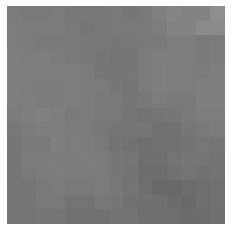

In [4]:
from matplotlib import pyplot as plt

px = 15

result_window = get_window(720,780, px)

plt.axis("off")

plt.imshow(result_window, cmap="gray", vmin=0, vmax=255)

## Tetsing the kmeans to different windows

In [8]:
import cv2
import commonmethods.image_modification as im

px = 15

window1 = get_window(658, 557, px)
window1 = window1.reshape((1, -1))
window2 = get_window(354, 610, px)
window2 = window2.reshape((1, -1))

values = np.vstack((window1,window2,window1, window2, window2, window1))

_, labels, _ = im.kmeans_segmentation(values, 2)

print(labels)

[0 1 0 1 1 0]


In [9]:
import cv2

px = 15

window_avokado1 = get_window(658, 557, px)
window_avokado2 = get_window(595, 600, px)
window_background = get_window(354, 610, px)
window_vase1 = get_window(600, 360, px)
window_vase2 = get_window(700, 320, px)
window_paprika = get_window(720, 780, px)

window_avokado1 = window_avokado1.reshape((1, -1))
window_avokado2 = window_avokado2.reshape((1, -1))
window_background = window_background.reshape((1, -1))
window_vase1 = window_vase1.reshape((1, -1))
window_vase2 = window_vase2.reshape((1, -1))
window_paprika = window_paprika.reshape((1, -1))

values = np.vstack((window_avokado1, window_avokado2, window_background, window_vase1, window_vase2, window_paprika))

_, labels, _ = im.kmeans_segmentation(values, 4)

print(labels)

[3 3 0 1 1 2]


## Getting the optimal cluster size

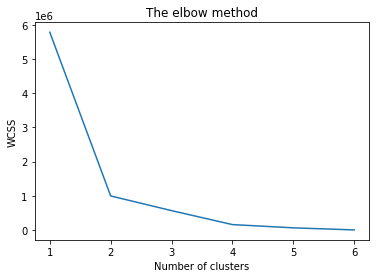

In [11]:
import commonmethods.image_modification as im

wcss = []   #within cluster sum of squares

for k in range(1, len(values)+1):
    compactness, _, _ = im.kmeans_segmentation(values, k)
    wcss.append(compactness)

plt.plot(range(1, len(values)+1), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [12]:
import commonmethods.image_modification as im
import commonmethods.optimal_cluster_number as ocn

#the best value and the cluster which resulted
s_closest = [0, 2]
db_min = [1000000, 2]
ch_max = [0, 2]

for i in range(2, len(values)):
        
    _, labels, _ = im.kmeans_segmentation(values, i)
    
    print(labels)

    s_time, s_score = ocn.silhouette_method(values, labels)
    db_time, db_score = ocn.davies_bouldin_method(values, labels)
    ch_time, ch_score = ocn.calinski_harabasz_method(values, labels)
    
    print("k: {}, S: {}, DB: {}, CH: {}".format(i, s_score, db_score, ch_score))
    
    #get the best cluster number for each methods
    if((1-s_score) < (1-s_closest[0])):
        s_closest = [s_score, i]

    if(db_score < db_min[0]):
        db_min = [db_score, i]

    if(ch_score > ch_max[0]):
        ch_max = [ch_score, i]
        
print(s_closest)
print(db_min)
print(ch_max)

[1 1 1 0 0 0]
k: 2, S: 0.6088057091586192, DB: 0.41480522637770867, CH: 19.275920557101347
[0 0 1 2 2 2]
k: 3, S: 0.41796989009749125, DB: 0.3376485967480675, CH: 13.86867563072763
[2 2 0 3 3 1]
k: 4, S: 0.31864072875699295, DB: 0.2468717328706374, CH: 24.127607461058723
[1 4 2 3 3 0]
k: 5, S: 0.17748781045486836, DB: 0.14182184305494533, CH: 23.532077701637338
[0.6088057091586192, 2]
[0.14182184305494533, 5]
[24.127607461058723, 4]


## Get windows

In [13]:
def get_window_values(window_quantity, px, height, width):
    
    pixels = np.zeros((window_quantity, 2))
    
    x = np.random.randint(0, height-px, window_quantity)
    y = np.random.randint(0, width-px, window_quantity)
    
    for i in range(window_quantity):
        window = get_window(x[i], y[i], px)
        window = window.reshape((1, -1))
        pixels[i] = [x[i], y[i]] #saving the start pixels of the frames
        
        if i == 0:
            result = np.array(window)
        else:
            result = np.vstack([result, window])
    
    return result, pixels

In [14]:
def get_window_values_with_intensity(window_quantity, px, height, width):
    
    pixels = np.zeros((window_quantity, 2))
    
    x = np.random.randint(0, height-px, window_quantity)
    y = np.random.randint(0, width-px, window_quantity)
    
    for i in range(window_quantity):
        window = get_window(x[i], y[i], px)
        window = window.reshape((1, -1))
        
        window = np.append(window, [[np.mean(window)]], axis = 1)
        
        pixels[i] = [x[i], y[i]] #saving the start pixels of the frames
        
        if i == 0:
            result = np.array(window)
        else:
            result = np.vstack([result, window])
    
    return result, pixels

In [15]:
def color_windows(image, labels, pixels, px):
    colored_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    colors = np.array([[0, 0, 135],[255, 0, 0], [255, 255, 0],[255, 150, 0],[0, 255, 0]])
    
    for i in range(len(labels)):
        colored_image[int(pixels[i][0]):int(pixels[i][0]+px), int(pixels[i][1]):int(pixels[i][1]+px)] = colors[labels[i]]
    
    return colored_image

In [16]:
def segment_and_color_image(values, k, pixels, px):
    _, labels, _ = im.kmeans_segmentation(values, k)

    return color_windows(resized_image, labels, pixels, px)

## Kmeans segmentation by texture (feature vector)

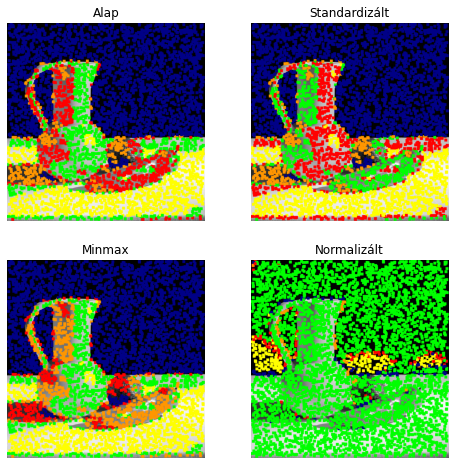

In [17]:
import cv2
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

px = 15
height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values(5000, px, height, width)

colored_base_image = segment_and_color_image(window_values, 5, pixels, px)

fig = plt.figure(figsize=(8,8))

image1 = fig.add_subplot(2,2,1)
image1.axis("off")
image1.set_title("Alap")
image1.imshow(colored_base_image, cmap="gray", vmin=0, vmax=255)

scale = StandardScaler()
scaled_data = scale.fit_transform(window_values)

colored_standard_image = segment_and_color_image(scaled_data, 5, pixels, px)

image2 = fig.add_subplot(2,2,2)
image2.axis("off")
image2.set_title("Standardizált")
image2.imshow(colored_standard_image, cmap="gray", vmin=0, vmax=255)
 
min_max_scaler = MinMaxScaler()
minmax = min_max_scaler.fit_transform(window_values)

colored_minmax_image = segment_and_color_image(minmax, 5, pixels, px)

image3 = fig.add_subplot(2,2,3)
image3.axis("off")
image3.set_title("Minmax")
image3.imshow(colored_minmax_image, cmap="gray", vmin=0, vmax=255)

normalized = normalize(window_values, norm='l2')

colored_normalize_image = segment_and_color_image(normalized, 5, pixels, px)

image4 = fig.add_subplot(2,2,4)
image4.axis("off")
image4.set_title("Normalizált")
image4.imshow(colored_normalize_image, cmap="gray", vmin=0, vmax=255)

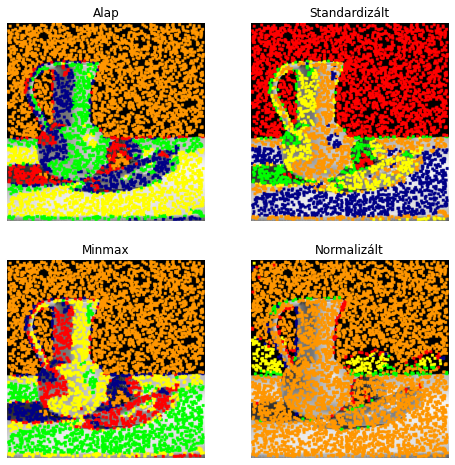

In [18]:
import cv2
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

px = 15
height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values_with_intensity(5000, px, height, width)

colored_base_image = segment_and_color_image(window_values, 5, pixels, px)

fig = plt.figure(figsize=(8,8))

image1 = fig.add_subplot(2,2,1)
image1.axis("off")
image1.set_title("Alap")
image1.imshow(colored_base_image, cmap="gray", vmin=0, vmax=255)

scale = StandardScaler()
scaled_data = scale.fit_transform(window_values)

colored_standard_image = segment_and_color_image(scaled_data, 5, pixels, px)

image2 = fig.add_subplot(2,2,2)
image2.axis("off")
image2.set_title("Standardizált")
image2.imshow(colored_standard_image, cmap="gray", vmin=0, vmax=255)
 
min_max_scaler = MinMaxScaler()
minmax = min_max_scaler.fit_transform(window_values)

colored_minmax_image = segment_and_color_image(minmax, 5, pixels, px)

image3 = fig.add_subplot(2,2,3)
image3.axis("off")
image3.set_title("Minmax")
image3.imshow(colored_minmax_image, cmap="gray", vmin=0, vmax=255)

normalized = normalize(window_values, norm='l2')

colored_normalize_image = segment_and_color_image(normalized, 5, pixels, px)

image4 = fig.add_subplot(2,2,4)
image4.axis("off")
image4.set_title("Normalizált")
image4.imshow(colored_normalize_image, cmap="gray", vmin=0, vmax=255)

## KNN classaification (feature vector)

[3]


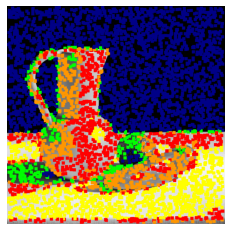

In [22]:
from sklearn.neighbors import KNeighborsClassifier
import commonmethods.image_modification as im

px = 15
height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values(5000, px, height, width)

k = 5
_, labels, _ = im.kmeans_segmentation(window_values, k)

cl_image = color_windows(resized_image, labels, pixels, px)

plt.axis("off")

plt.imshow(cl_image)

knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(window_values, labels)

test_window = get_window(300, 300, px)

test_window = test_window.reshape((1, -1))

predicted= knn_model.predict(test_window)
print(predicted)

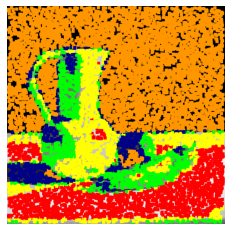

In [36]:
plus_window_values, plus_pixels = get_window_values(5000, px, height, width)

plus_labels = np.empty(5000, dtype=int)

for i in range(len(plus_window_values)):
    test_window = plus_window_values[i].reshape((1, -1))

    predicted = knn_model.predict(test_window)
            
    plus_labels[i] = int(predicted)
    
plus_cl_image = cl_image

colors = np.array([[0, 0, 135],[255, 0, 0], [255, 255, 0],[255, 150, 0],[0, 255, 0]])
    
for i in range(len(plus_labels)):
    plus_cl_image[int(plus_pixels[i][0]):int(plus_pixels[i][0]+px), int(plus_pixels[i][1]):int(plus_pixels[i][1]+px)] = colors[plus_labels[i]]

plt.axis("off")

plt.imshow(plus_cl_image)

In [38]:
#np.any(np.all(array_to_check == list_np_arrays, axis=1))

test_pixels = []
test_labels = []

for i in range(height-px):
    for j in range(width-px):
        if(cl_image[i][j][0] == cl_image[i][j][1] and cl_image[i][j][0] == cl_image[i][j][2]):
            test_window = get_window(i, j, px)

            test_window = test_window.reshape((1, -1))

            predicted = knn_model.predict(test_window)
            
            test_pixels.append([i, j])
            
            test_labels.append(predicted)

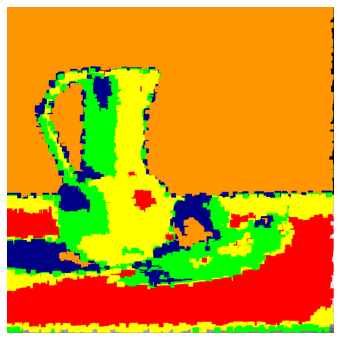

In [39]:
colored_image_test = cl_image

colors = np.array([[0, 0, 135],[255, 0, 0], [255, 255, 0],[255, 150, 0],[0, 255, 0]])
    
for i in range(len(test_labels)):
    colored_image_test[int(test_pixels[i][0]):int(test_pixels[i][0]+px), int(test_pixels[i][1]):int(test_pixels[i][1]+px)] = colors[test_labels[i]]

plt.figure(figsize=(6,6))
    
plt.axis("off")

plt.imshow(colored_image_test)

## KNN classification (all pixels)

C:\Users\Fanni\AppData\Local\Temp\ipykernel_7132\3374965122.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_labels = np.array(all_labels)


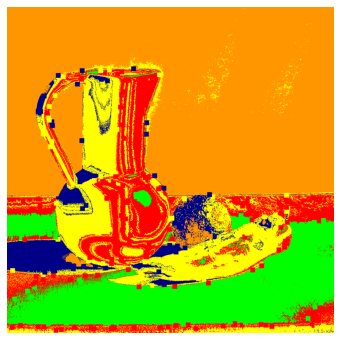

In [30]:
from sklearn.neighbors import KNeighborsClassifier
import commonmethods.image_modification as im

px = 15
height = resized_image.shape[0]
width = resized_image.shape[1]

window_values, pixels = get_window_values(1000, px, height, width)

k = 5
_, labels, _ = im.kmeans_segmentation(window_values, k)

cl_image = color_windows(resized_image, labels.flatten(), pixels, px)

all_labels = []
all_pixels = []

for i in range(len(pixels)):
    for j in range(0, px):
        for k in range(0, px):
            all_pixels.append([int(pixels[i][0]+j), int(pixels[i][1]+k)])
            all_labels.append(labels[i])

window_values = window_values.reshape((-1, 1))

knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(window_values, all_labels)

for i in range(height):
    for j in range(width):
        if(cl_image[i][j][0] == cl_image[i][j][1] and cl_image[i][j][0] == cl_image[i][j][2]):
            test_pixel = resized_image[i][j]
            test_pixel = test_pixel.reshape((1, -1))
            
            predicted= knn_model.predict(test_pixel)
            
            all_pixels.append([i, j])
            all_labels.append(predicted)

all_pixels = np.array(all_pixels)
all_labels = np.array(all_labels)

colored_image_test = cl_image

colors = np.array([[0, 0, 135],[255, 0, 0], [255, 255, 0],[255, 150, 0],[0, 255, 0]])
    
for i in range(len(all_labels)):
    colored_image_test[int(all_pixels[i][0]), int(all_pixels[i][1])] = colors[all_labels[i]]
    
plt.figure(figsize=(6,6))
    
plt.axis("off")

plt.imshow(colored_image_test)